In [ ]:
import pandas as pd
import numpy as np
import sqlite3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run this for Tiana's drive
path = "/content/drive/MyDrive/Colab_Notebooks/DataWarehousingBusinessIntelligence/Coursework2/bank_transactions.csv"
df_transactions = pd.read_csv(path)

In [ ]:
# # run this for Mahnoor's drive
# path = "/content/drive/Shared with me/Coursework2/"

# df_transactions = pd.read_csv(path + "bank_transactions.csv")

# Task A:
## Data Understanding

In [ ]:
# Create and connect to database
conn = sqlite3.connect("bank_transaction_db")
cur = conn.cursor()

# create table: transactions
df_transactions.to_sql("transactions", conn, if_exists='replace', index=False)

1048567

### Identify and remove the following:
1. null values
2. invalid transaction amount values
3. invalid age values
4. invalid location values

In [ ]:
# Clean Database
conn.execute('''
  DELETE FROM transactions
  WHERE CustomerDOB IS NULL
    OR CustGender IS NULL
    OR CustLocation IS NULL
    OR CustLocation IS 'None'
    OR CustAccountBalance IS NULL
    OR "TransactionAmount (INR)" < 1
    OR CustomerDOB IS "1/1/1800"
''')

cleaned_db = pd.read_sql('SELECT * FROM transactions', conn)
cleaned_db

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
984344,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
984345,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
984346,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
984347,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


(

In [ ]:
# Get the first 1000 unique locations
locations = pd.read_sql('''
    SELECT CustLocation, COUNT(CustLocation) AS TransactionFrequency
    FROM transactions
    GROUP BY CustLocation
    ORDER BY TransactionFrequency DESC
    LIMIT 1000
''', conn)

# If the location contains any of the first 1000 locations in its name,
# replace with just the location name (gets rid of addresses)
def match_location(loc):
    for location in locations:
        if location.upper() in loc.upper():
            return location
    return None

# Apply the function to the column
cleaned_db['CustLocation'] = cleaned_db['CustLocation'].apply(match_location)
cleaned_db['TransactionDate'] = pd.to_datetime(cleaned_db['TransactionDate'])

# Drop any other location not listed in the first 1000
cleaned_db = cleaned_db[~cleaned_db['CustLocation'].isin(['None', '', None])]
cleaned_db.to_sql('transactions', conn, if_exists='replace', index=False)
cleaned_db

<ipython-input-55-abd57e79cf9a>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_db['TransactionDate'] = pd.to_datetime(cleaned_db['TransactionDate'])


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,24/3/88,F,MUMBAI,6714.43,2016-02-08,181156,1762.5
...,...,...,...,...,...,...,...,...,...
984344,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,2016-09-18,184824,799.0
984345,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,2016-09-18,183734,460.0
984346,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,2016-09-18,183313,770.0
984347,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0


### Show the top 5 locations where the maximum number of transactions occured

In [ ]:
location_frequency_df = pd.read_sql('''
    SELECT CustLocation, COUNT(CustLocation) AS TransactionFrequency
    FROM transactions
    GROUP BY CustLocation
    ORDER BY TransactionFrequency DESC
    LIMIT 5
''', conn)

location_frequency_df

,CustLocation,TransactionFrequency
0,MUMBAI,125653
1,BANGALORE,84418
2,NEW DELHI,76961
3,GURGAON,70953
4,DELHI,68621


## Define & Calculate RFM Values per Customer

### Write a query to define and calculate the RFM values per customer

In [ ]:
customer_rfm = pd.read_sql('''
WITH loc_ranks AS (
    SELECT
        CustomerID,
        CustLocation,
        COUNT(*) AS location_count,
        RANK() OVER (PARTITION BY CustomerID ORDER BY COUNT(*) DESC, CustLocation) AS loc_rank
    FROM transactions
    GROUP BY CustomerID, CustLocation
),
most_frequent_location AS (
    SELECT
        CustomerID,
        CustLocation
    FROM loc_ranks
    WHERE loc_rank = 1
),
rfm AS (
    SELECT
        CustomerID,
        MAX(TransactionDate) AS Recency,
        COUNT(CustomerID) AS Frequency,
        SUM("TransactionAmount (INR)") AS MonetaryValue
    FROM transactions
    GROUP BY CustomerID
)
SELECT
    rfm.CustomerID,
    rfm.Recency,
    rfm.Frequency,
    rfm.MonetaryValue,
    loc.CustLocation
FROM rfm
LEFT JOIN most_frequent_location loc ON rfm.CustomerID = loc.CustomerID;
''', conn)
customer_rfm

,CustomerID,Recency,Frequency,MonetaryValue,CustLocation
0,C1010011,2016-09-26 00:00:00,2,5106.0,NEW DELHI
1,C1010012,2016-08-14 00:00:00,1,1499.0,MUMBAI
2,C1010014,2016-07-08 00:00:00,2,1455.0,MUMBAI
3,C1010018,2016-09-15 00:00:00,1,30.0,CHAMPARAN
4,C1010024,2016-08-18 00:00:00,1,5000.0,KOLKATA
...,...,...,...,...,...
806864,C9099836,2016-07-08 00:00:00,1,691.0,BHIWANDI
806865,C9099877,2016-09-15 00:00:00,1,222.0,BANGALORE
806866,C9099919,2016-08-18 00:00:00,1,126.0,GUNTUR
806867,C9099941,2016-08-28 00:00:00,1,50.0,CHENNAI


In [ ]:
# change Recency to datetime
customer_rfm['Recency'] = pd.to_datetime(customer_rfm['Recency'])
customer_rfm.dtypes

,0
CustomerID,object
Recency,datetime64[ns]
Frequency,int64
MonetaryValue,float64
CustLocation,object


In [ ]:
# Create date variable that records recency
import datetime

# Create snapshot date of the most recent transaction date
snapshot_date = customer_rfm['Recency'].max() + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = customer_rfm.groupby(['CustomerID']).agg({
   'Recency': lambda x: (snapshot_date - x.max()).days,
   'Frequency':'sum' ,
   'MonetaryValue': 'sum',
   'CustLocation': lambda x: x
   })
customers

,Recency,Frequency,MonetaryValue,CustLocation
CustomerID,,,,
C1010011,75,2,5106.0,NEW DELHI
C1010012,118,1,1499.0,MUMBAI
C1010014,155,2,1455.0,MUMBAI
C1010018,86,1,30.0,CHAMPARAN
C1010024,114,1,5000.0,KOLKATA
...,...,...,...,...
C9099836,155,1,691.0,BHIWANDI
C9099877,86,1,222.0,BANGALORE
C9099919,114,1,126.0,GUNTUR


In [ ]:
customers[customers["MonetaryValue"] < 0]

,Recency,Frequency,MonetaryValue,CustLocation
CustomerID,,,,


### Check the distribution of recency, frequency, and monetary values

#### Plot RFM Distributions (not transformed)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-62-51a9a0196725>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
<ipython-input-62-51a9a0196725>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
<ipython-input-62-51a9a0196725>:6: UserWarni

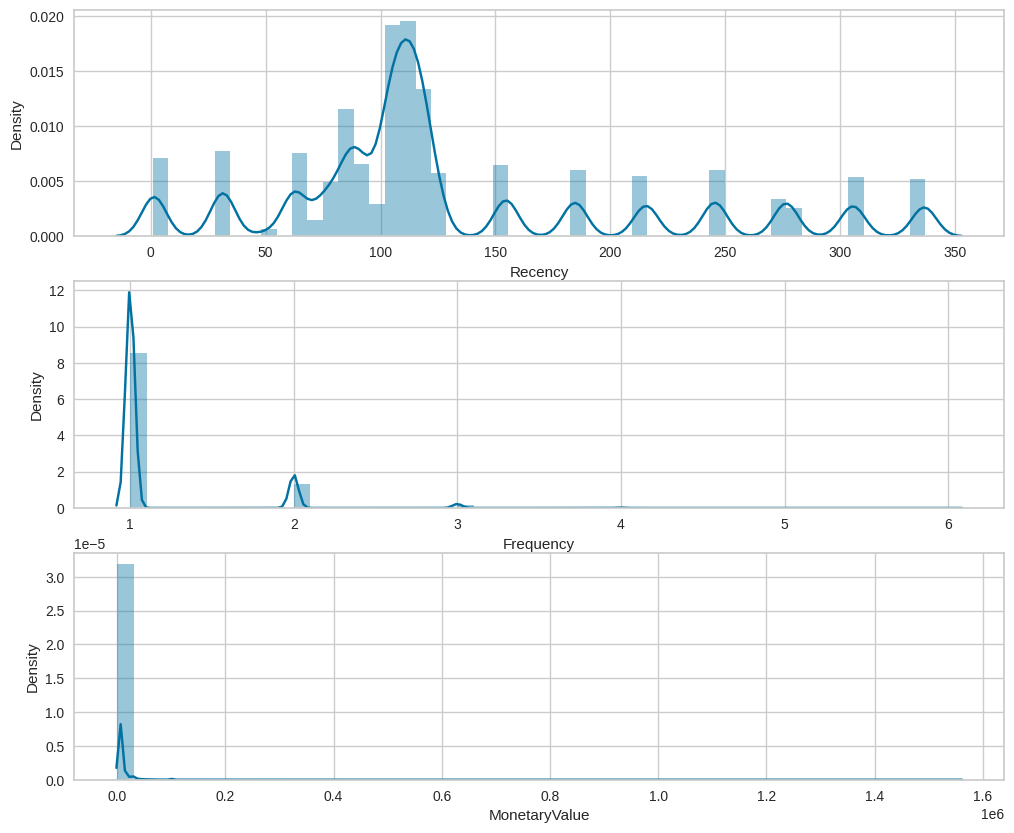

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'])

plt.show()

### Remove skew from the data
#### Plot RFM (transformed)
We decided that box cox was the best

In [ ]:
import numpy as np
from scipy import stats

transformed_data_bc = pd.DataFrame()
transformed_data_bc["CustLocation"] = customers["CustLocation"]
transformed_data_bc["Recency"] = stats.boxcox(customers['Recency'])[0]
transformed_data_bc["Frequency"] = stats.boxcox(customers['Frequency'])[0]
transformed_data_bc["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
transformed_data_bc

,CustLocation,Recency,Frequency,MonetaryValue
CustomerID,,,,
C1010011,NEW DELHI,18.573983,0.110693,10.308162
C1010012,MUMBAI,24.520896,0.000000,8.587059
C1010014,MUMBAI,28.908263,0.110693,8.546337
C1010018,CHAMPARAN,20.212022,0.000000,3.661379
C1010024,KOLKATA,24.012829,0.000000,10.277936
...,...,...,...,...
C9099836,BHIWANDI,28.908263,0.000000,7.545232
C9099877,BANGALORE,20.212022,0.000000,6.078814
C9099919,GUNTUR,24.012829,0.000000,5.373558


In [ ]:
import numpy as np
from scipy import stats

transformed_data_bc = pd.DataFrame()
transformed_data_bc["CustLocation"] = customers["CustLocation"]
transformed_data_bc["Recency"] = stats.boxcox(customers['Recency'])[0]
transformed_data_bc["Frequency"] = stats.boxcox(customers['Frequency'])[0]
# Ensure all MonetaryValues are positive for Box-Cox transformation
# Add a small positive constant to shift values if necessary
transformed_data_bc["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'] + 1e-8)[0]
transformed_data_bc

,CustLocation,Recency,Frequency,MonetaryValue
CustomerID,,,,
C1010011,NEW DELHI,18.573983,0.110693,10.308162
C1010012,MUMBAI,24.520896,0.000000,8.587059
C1010014,MUMBAI,28.908263,0.110693,8.546337
C1010018,CHAMPARAN,20.212022,0.000000,3.661379
C1010024,KOLKATA,24.012829,0.000000,10.277937
...,...,...,...,...
C9099836,BHIWANDI,28.908263,0.000000,7.545232
C9099877,BANGALORE,20.212022,0.000000,6.078814
C9099919,GUNTUR,24.012829,0.000000,5.373559


<ipython-input-65-13951dcc732a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(transformed_data_bc['Recency'])
<ipython-input-65-13951dcc732a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(transformed_data_bc['Frequency'])
<ipython-input-65-13951d

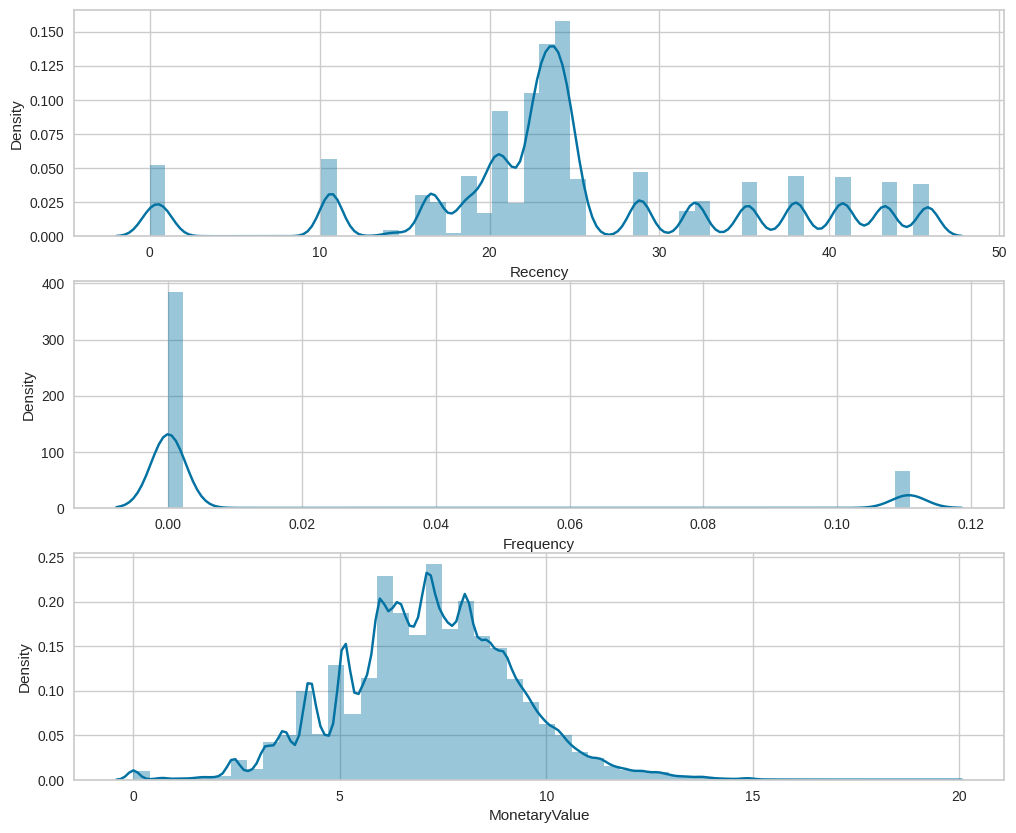

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(transformed_data_bc['Recency'])
plt.subplot(3, 1, 2); sns.distplot(transformed_data_bc['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(transformed_data_bc['MonetaryValue'])

plt.show()

# Task B: Customer segmentation with k-means

In [ ]:
transformed_data_bc.head()

,CustLocation,Recency,Frequency,MonetaryValue
CustomerID,,,,
C1010011,NEW DELHI,18.573983,0.110693,10.308162
C1010012,MUMBAI,24.520896,0.000000,8.587059
C1010014,MUMBAI,28.908263,0.110693,8.546337
C1010018,CHAMPARAN,20.212022,0.000000,3.661379
C1010024,KOLKATA,24.012829,0.000000,10.277937


### Checking correlation
We do not see any correlation between the variables so we can run k-means

<function matplotlib.pyplot.show(close=None, block=None)>

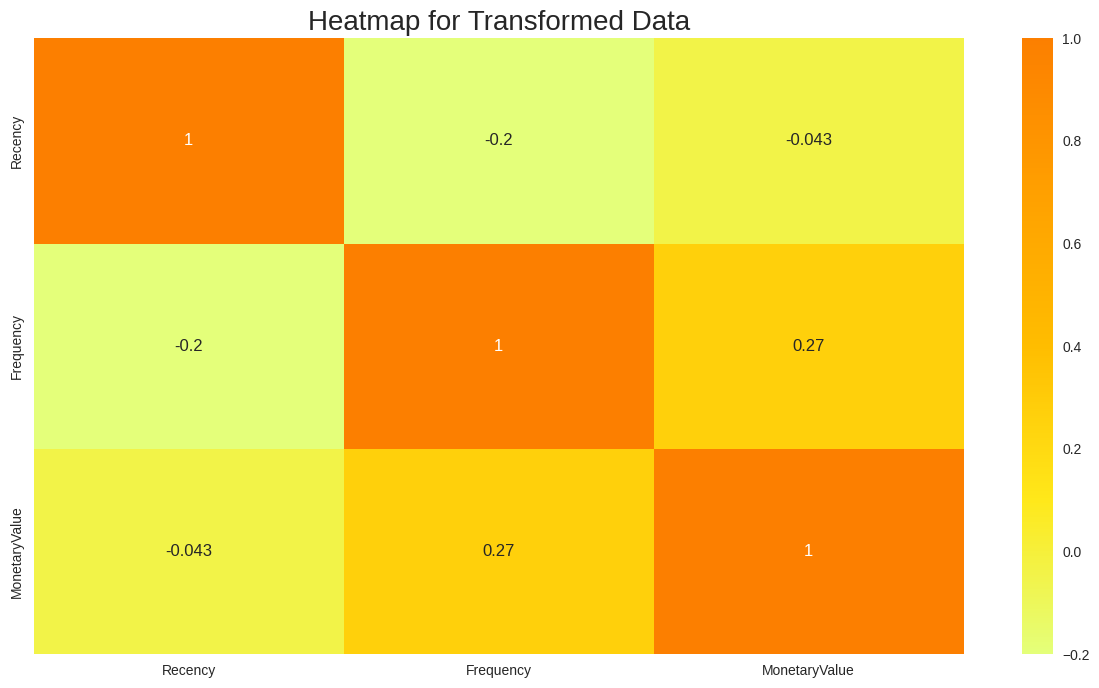

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(transformed_data_bc.select_dtypes(include='number').corr(), cmap='Wistia', annot = True)
plt.title('Heatmap for Transformed Data', fontsize = 20)
plt.show

## K-means:
Standardize the data so all measurements have a mean of 0 and a standard deviation of 1

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(transformed_data_bc.select_dtypes(include='number'))
customers_normalized = scaler.transform(transformed_data_bc.select_dtypes(include='number'))

# Check that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0.  0.]
[1. 1. 1.]


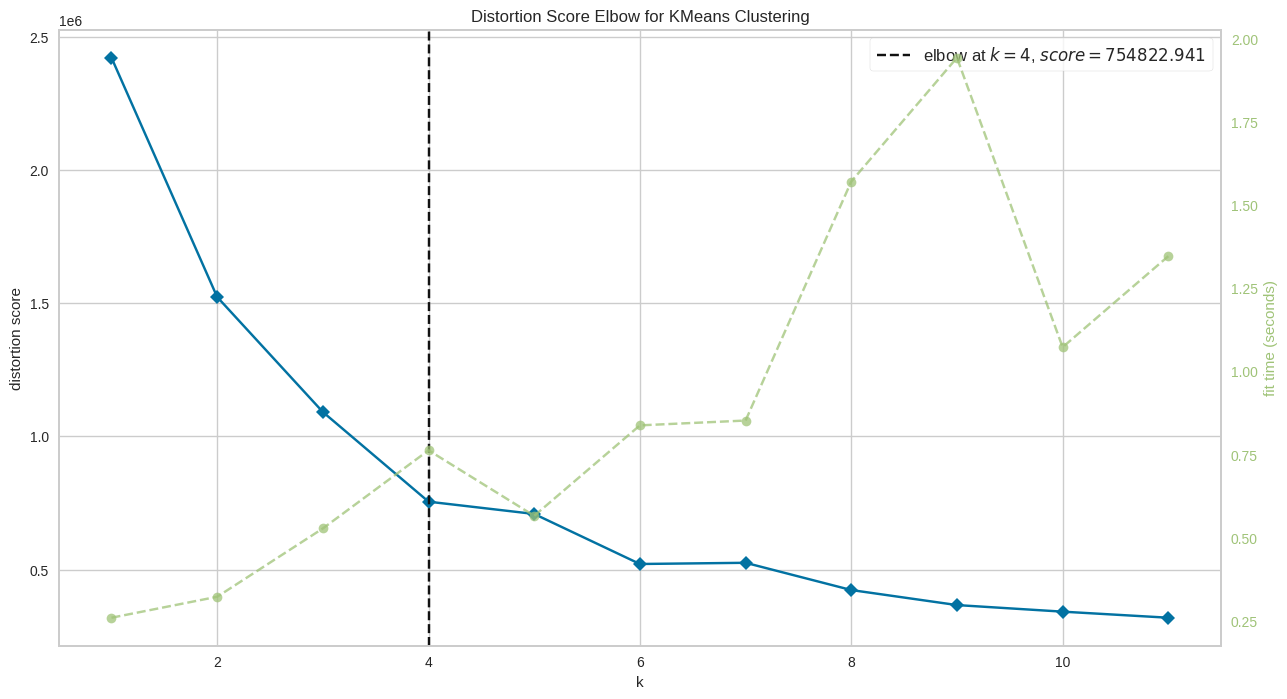

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

,CustLocation,Recency,Frequency,MonetaryValue
Cluster,,,,
0,277084,277084,277084,277084
1,281363,281363,281363,281363
2,129396,129396,129396,129396
3,119026,119026,119026,119026


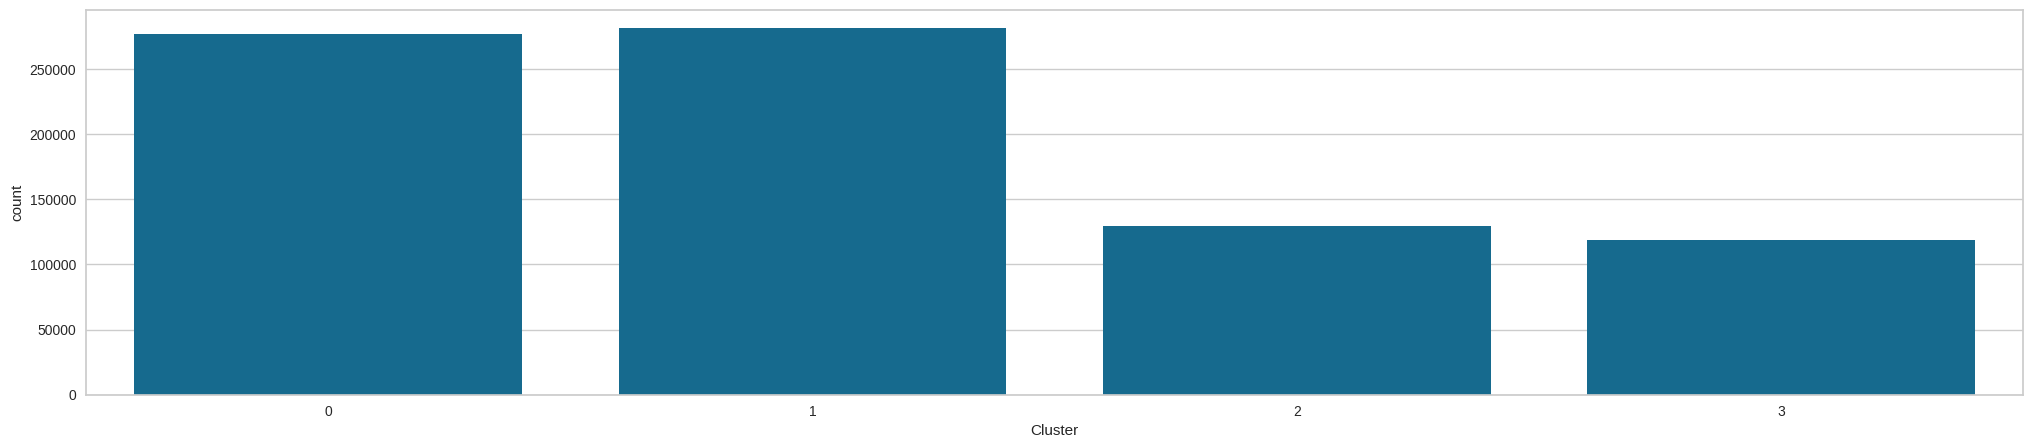

In [ ]:
model = KMeans(n_clusters = 4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

transformed_data_bc["Cluster"] = model.labels_

f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=transformed_data_bc)
transformed_data_bc.groupby(['Cluster']).count()

In [ ]:
transformed_data_bc.groupby('Cluster').agg({
  'Recency': 'mean',
  'Frequency': 'mean',
  'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue        
           mean      mean          mean   count
Cluster                                        
0         27.24      0.00          5.16  277084
1         29.55      0.00          8.56  281363
2         12.78      0.00          7.18  129396
3         19.85      0.11          8.50  119026

In [ ]:
# Ensure clusters are assigned to each value
transformed_data_bc.head()

,CustLocation,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,,
C1010011,NEW DELHI,18.573983,0.110693,10.308162,3
C1010012,MUMBAI,24.520896,0.000000,8.587059,1
C1010014,MUMBAI,28.908263,0.110693,8.546337,3
C1010018,CHAMPARAN,20.212022,0.000000,3.661379,0
C1010024,KOLKATA,24.012829,0.000000,10.277937,1


In [ ]:
# create a normalized dataframe and melt it to include other column data
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = transformed_data_bc.index
df_normalized['Cluster'] = model.labels_
df_melt = pd.melt(df_normalized.reset_index(),
                  id_vars=['ID', 'Cluster'],
                  value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                  var_name='Attribute',
                  value_name='Value'
                  )
df_melt.head()

,ID,Cluster,Attribute,Value
0,C1010011,3,Recency,-0.609785
1,C1010012,1,Recency,-0.011701
2,C1010014,3,Recency,0.429538
3,C1010018,0,Recency,-0.445047
4,C1010024,1,Recency,-0.062798


<Axes: xlabel='Attribute', ylabel='Value'>

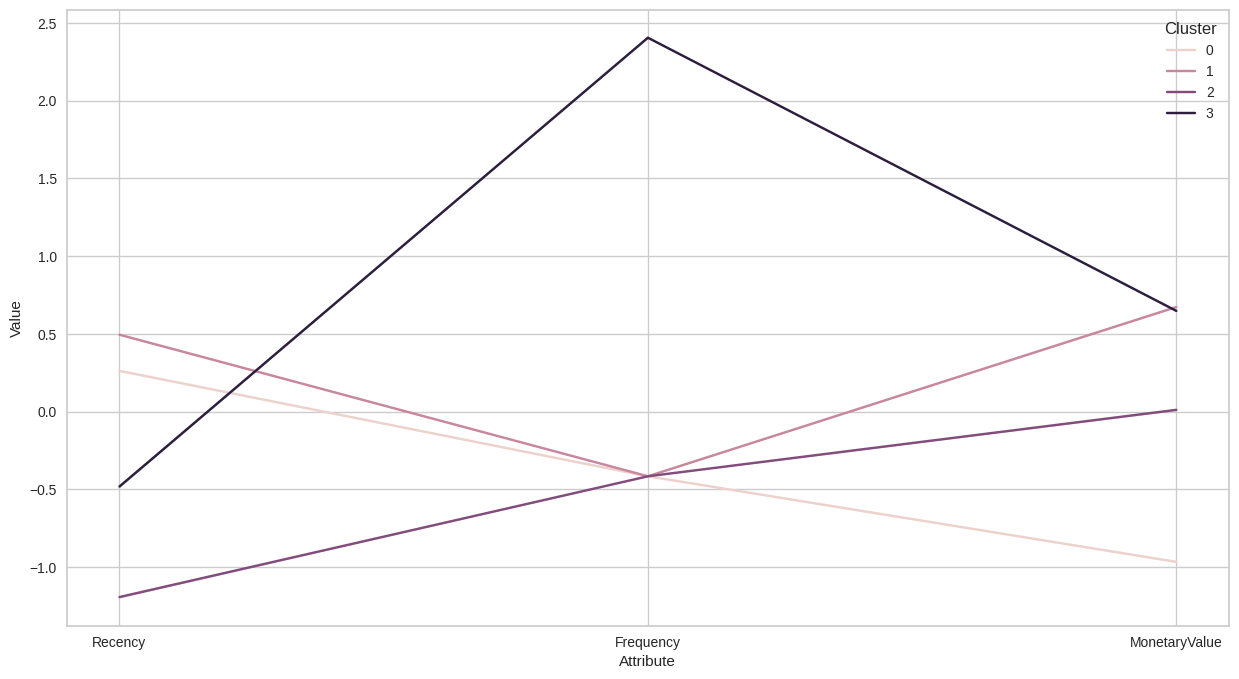

In [ ]:
sns.lineplot(x = 'Attribute', y= 'Value', hue='Cluster', data=df_melt)

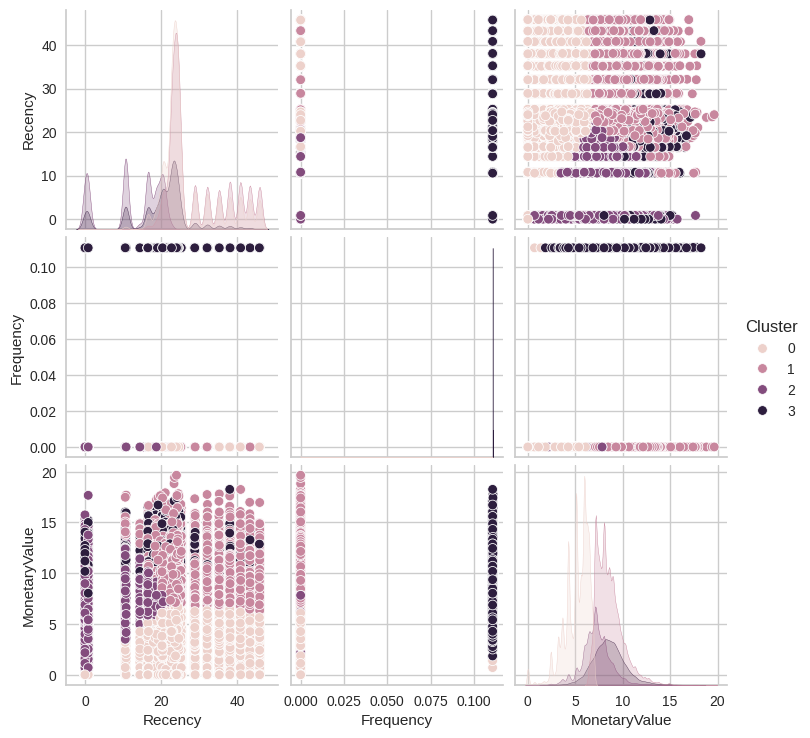

In [ ]:
sns.pairplot(transformed_data_bc.select_dtypes(include='number'), hue='Cluster', diag_kind='kde')
plt.show()

# Task C:
By Location

,Recency,Frequency,MonetaryValue,CustLocation
Cluster,,,,
0,277084,277084,277084,277084
1,281363,281363,281363,281363
2,129396,129396,129396,129396
3,119026,119026,119026,119026


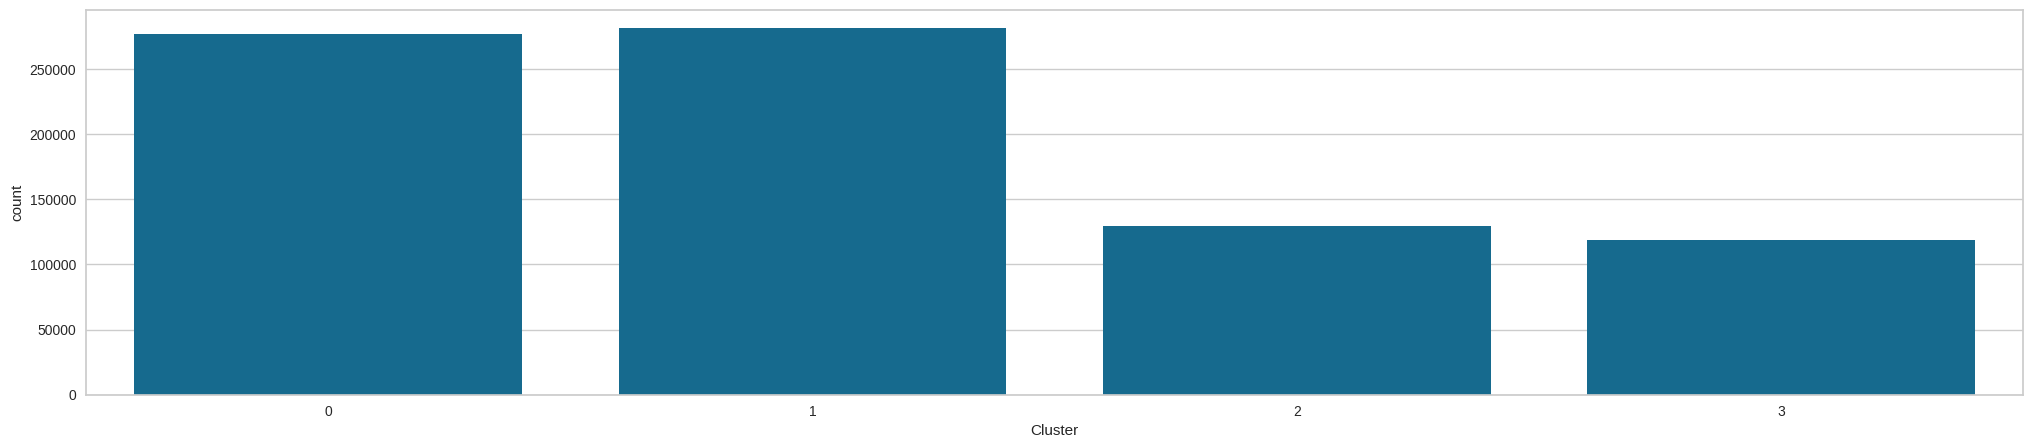

In [ ]:
customers["Cluster"] = model.labels_

f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=transformed_data_bc)
customers.groupby(['Cluster']).count()

In [ ]:
customers.groupby('Cluster').agg({
  'Recency': 'mean',
  'Frequency': 'mean',
  'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue        
           mean      mean          mean   count
Cluster                                        
0        147.01      1.00        153.40  277084
1        168.15      1.00       2938.54  281363
2         49.14      1.00       1043.44  129396
3         91.73      2.13       3085.20  119026

In [ ]:
top_five_locations = location_frequency_df['CustLocation'].values
top_five_results = {}

for loc in top_five_locations:
  top_five_results[f"{loc.lower().replace(' ', '_')}_clusters"] = (
    customers[customers["CustLocation"] == loc].groupby('Cluster').agg({
      'Recency': 'mean',
      'Frequency': ['mean', 'max'],
      'MonetaryValue': ['mean', 'median', 'count']
    }).round(2)
  )

In [ ]:
top_five_results["mumbai_clusters"]

Recency Frequency     MonetaryValue                
           mean      mean max          mean   median  count
Cluster                                                    
0        146.41      1.00   1        170.36   163.00  31279
1        167.44      1.00   1       2862.11  1282.00  42826
2         49.99      1.00   1       1079.24   556.74  17860
3         91.51      2.11   6       3314.41  1485.00  11328

In [ ]:
top_five_results["bangalore_clusters"]

Recency Frequency     MonetaryValue               
           mean      mean max          mean  median  count
Cluster                                                   
0        147.91      1.00   1        174.01   171.0  24431
1        173.78      1.00   1       2731.14  1060.0  25555
2         50.70      1.00   1        901.68   500.0  11696
3         92.46      2.16   5       3059.67  1350.0  20158

In [ ]:
top_five_results["new_delhi_clusters"]

Recency Frequency     MonetaryValue                
           mean      mean max          mean   median  count
Cluster                                                    
0        146.57      1.00   1        159.49   142.98  20442
1        164.15      1.00   1       3232.26  1299.00  24804
2         49.10      1.00   1       1188.07   533.00  10747
3         92.60      2.09   5       3253.39  1463.90   4815

In [ ]:
top_five_results["gurgaon_clusters"]

Recency Frequency     MonetaryValue               
           mean      mean max          mean  median  count
Cluster                                                   
0        149.84      1.00   1        162.93   147.0  20220
1        170.04      1.00   1       2772.26  1200.0  22082
2         49.85      1.00   1       1123.55   500.0   9859
3         92.05      2.12   5       3054.01  1390.2  10841

In [ ]:
top_five_results["delhi_clusters"]

Recency Frequency     MonetaryValue               
           mean      mean max          mean  median  count
Cluster                                                   
0        147.22      1.00   1        150.88   120.0  20036
1        166.54      1.00   1       2761.08  1200.0  20409
2         49.58      1.00   1       1025.41   500.0   9643
3         91.28      2.13   5       3058.76  1390.0  13229

In [ ]:
top_five_results

{'mumbai_clusters':         Recency Frequency     MonetaryValue                
            mean      mean max          mean   median  count
 Cluster                                                    
 0        146.41      1.00   1        170.36   163.00  31279
 1        167.44      1.00   1       2862.11  1282.00  42826
 2         49.99      1.00   1       1079.24   556.74  17860
 3         91.51      2.11   6       3314.41  1485.00  11328,
 'bangalore_clusters':         Recency Frequency     MonetaryValue               
            mean      mean max          mean  median  count
 Cluster                                                   
 0        147.91      1.00   1        174.01   171.0  24431
 1        173.78      1.00   1       2731.14  1060.0  25555
 2         50.70      1.00   1        901.68   500.0  11696
 3         92.46      2.16   5       3059.67  1350.0  20158,
 'new_delhi_clusters':         Recency Frequency     MonetaryValue                
            mean      mean 

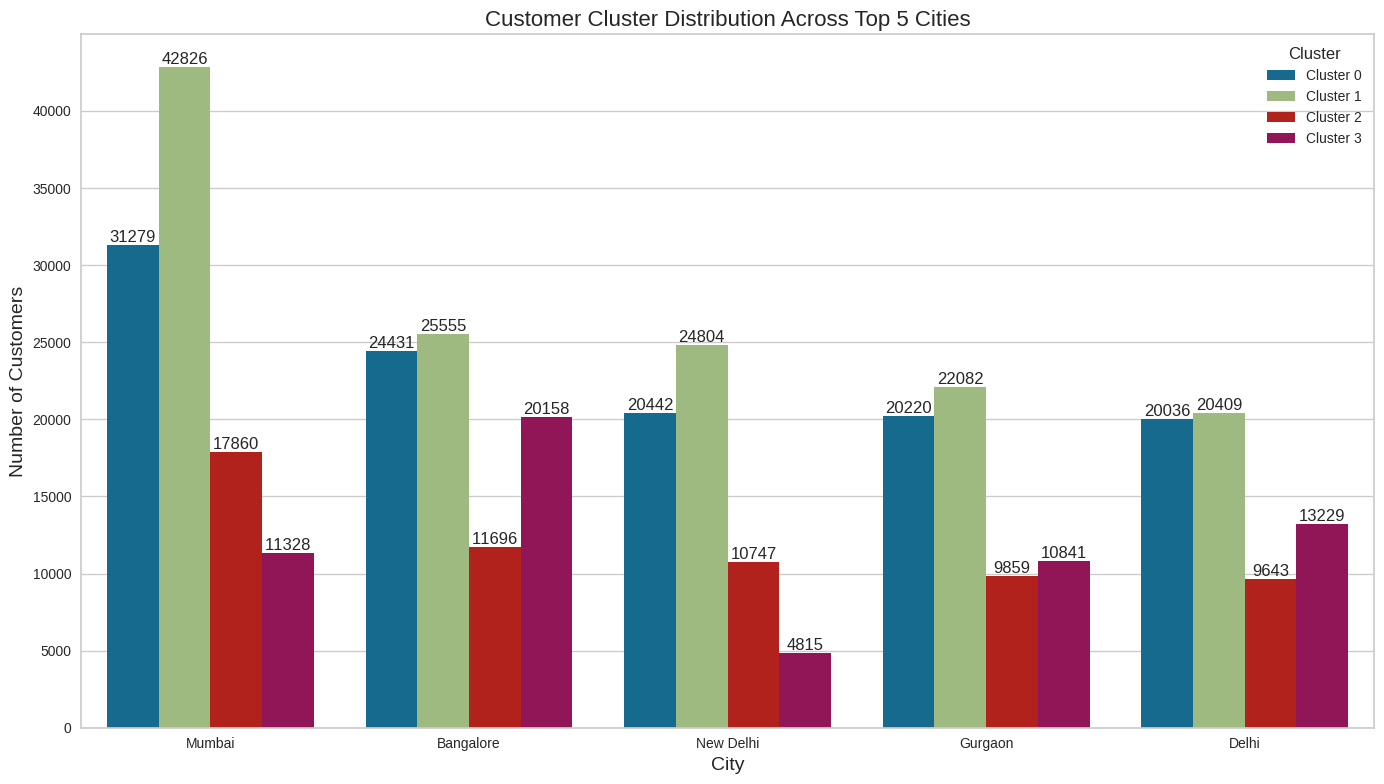

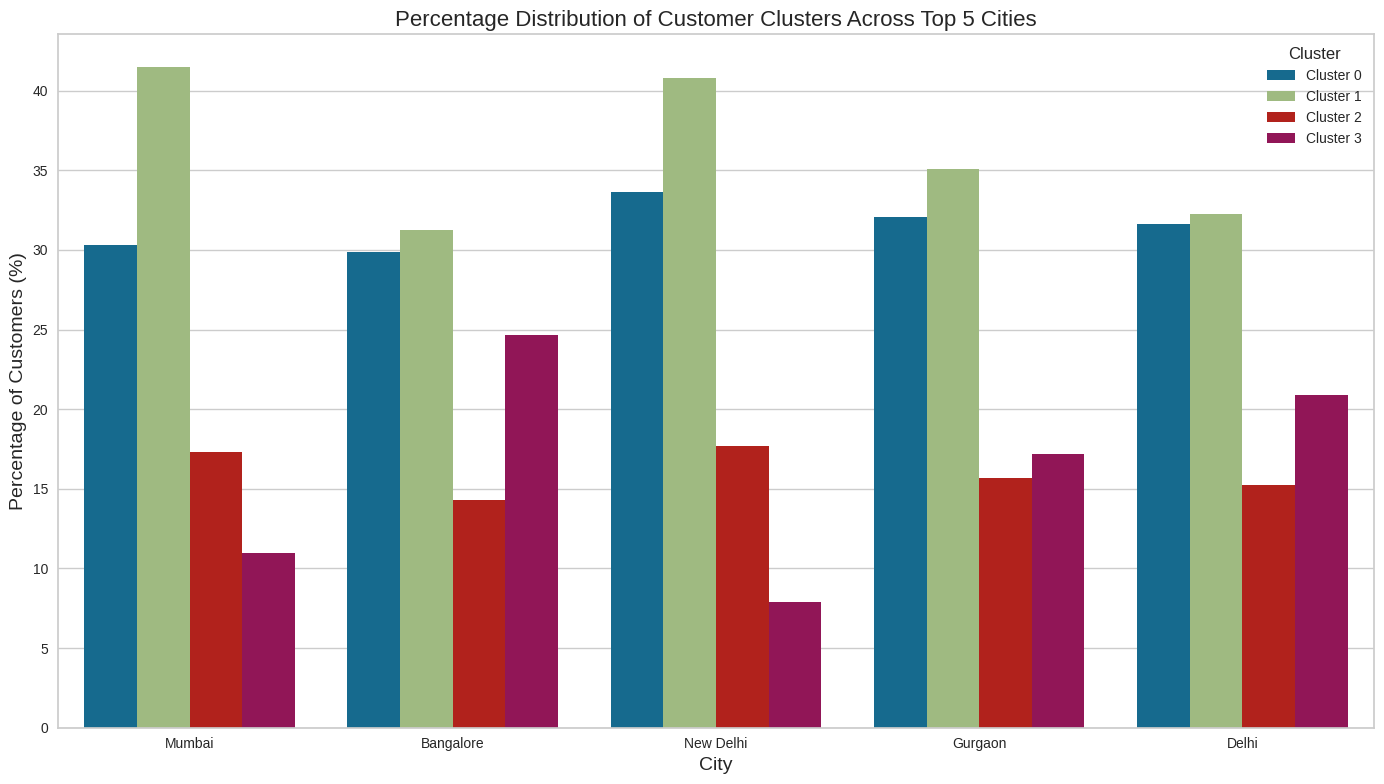

In [ ]:
#Visualization of clusters per city (Top5)
# Create a dataframe for visualization
cities = ['Mumbai', 'Bangalore', 'New Delhi', 'Gurgaon', 'Delhi']
clusters = [0, 1, 2, 3]

# Extract counts from our results
data = []
for city in cities:
    city_key = f"{city.lower().replace(' ', '_')}_clusters"
    for cluster in clusters:
        count = top_five_results[city_key].loc[cluster, ('MonetaryValue',  'count')]
        data.append([city, f"Cluster {cluster}", count])

df_viz = pd.DataFrame(data, columns=['City', 'Cluster', 'Count'])

# Create the visualization
plt.figure(figsize=(14, 8))
chart = sns.barplot(x='City', y='Count', hue='Cluster', data=df_viz)

# Add labels and title
plt.title('Customer Cluster Distribution Across Top 5 Cities', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.legend(title='Cluster')

# Add value labels on the bars
for container in chart.containers:
    chart.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

#Create a stacked percentage chart to show proportion
plt.figure(figsize=(14, 8))
df_percentage = df_viz.copy()
city_totals = df_viz.groupby('City')['Count'].sum().reset_index()
df_viz = df_viz.merge(city_totals, on='City', suffixes=('', '_total'))
df_viz['Percentage'] = df_viz['Count'] / df_viz['Count_total'] * 100

chart = sns.barplot(x='City', y='Percentage', hue='Cluster', data=df_viz)

plt.title('Percentage Distribution of Customer Clusters Across Top 5 Cities', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Percentage of Customers (%)', fontsize=14)
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# Appendix

In [ ]:
transformed_data_log = pd.DataFrame()
transformed_data_log["Recency"] = np.log1p(customers['Recency'])
transformed_data_log["Frequency"] = np.log1p(customers['Frequency'])
transformed_data_log["MonetaryValue"] = np.log1p(customers['MonetaryValue'])
transformed_data_log.tail()

transformed_data_ln = pd.DataFrame()
transformed_data_ln["Recency"] = np.log(customers['Recency'])
transformed_data_ln["Frequency"] = np.log(customers['Frequency'])
transformed_data_ln["MonetaryValue"] = np.log(customers['MonetaryValue'])
transformed_data_ln.tail()

,Recency,Frequency,MonetaryValue
CustomerID,,,
C9099836,5.043425,0.0,6.538140
C9099877,4.454347,0.0,5.402677
C9099919,4.736198,0.0,4.836282
C9099941,4.644391,0.0,3.912023
C9099956,4.330733,0.0,6.751101


<ipython-input-87-70a37f88e94a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(transformed_data_ln['Recency'])
<ipython-input-87-70a37f88e94a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(transformed_data_ln['Frequency'])
<ipython-input-87-70a37f

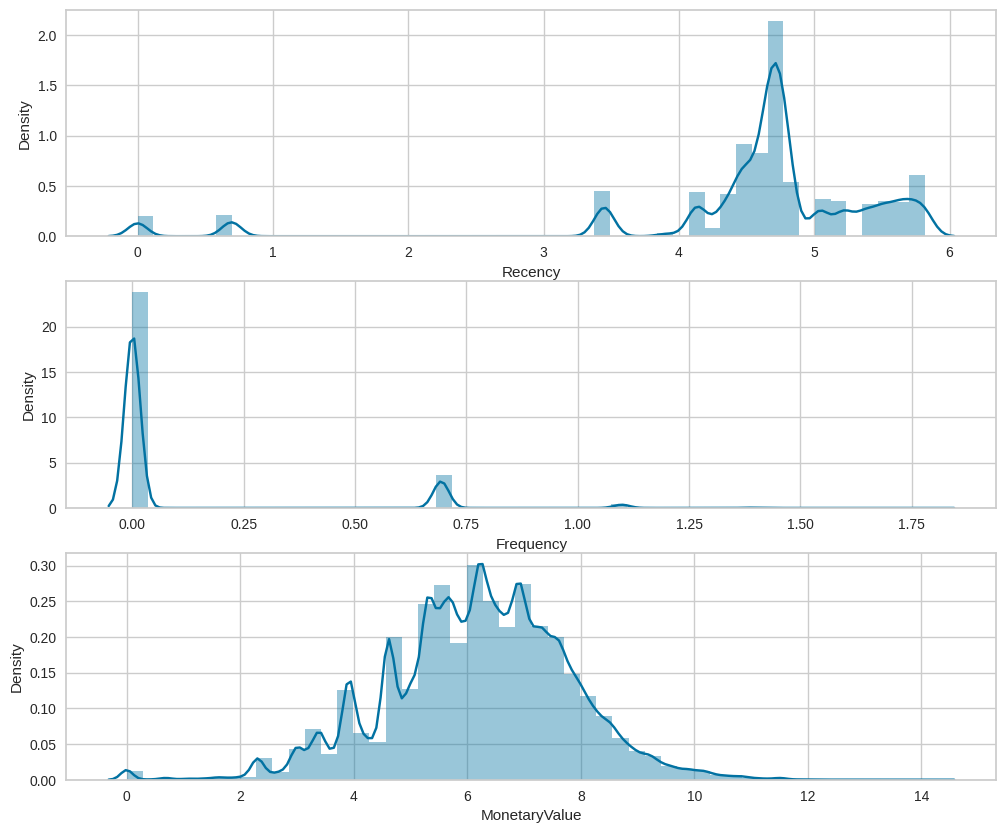

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(transformed_data_ln['Recency'])
plt.subplot(3, 1, 2); sns.distplot(transformed_data_ln['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(transformed_data_ln['MonetaryValue'])

plt.show()

<ipython-input-88-f2ba697a3470>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(transformed_data_log['Recency'])
<ipython-input-88-f2ba697a3470>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(transformed_data_log['Frequency'])
<ipython-input-88-f2ba

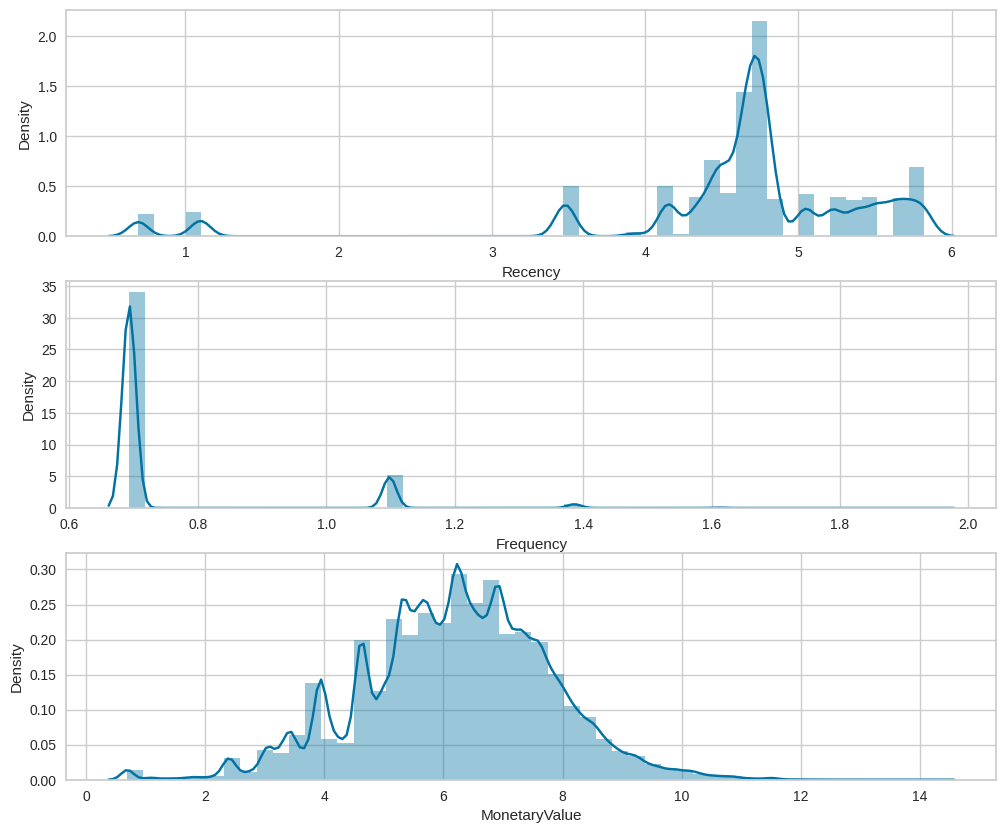

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(transformed_data_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(transformed_data_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(transformed_data_log['MonetaryValue'])

plt.show()